In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint ,  solve_ivp
import datetime

from sys import platform

if platform == "darwin":
    folder="/Users/sjha/Documents/Github/new_model_data/"  ## mac
if platform == "win32":
    folder="C:\\Users\\jhash\\Documents\\renders\\opto\\" ## windows

print(folder)


C:\Users\jhash\Documents\renders\opto\


In [4]:
g_y=1.24e6   ##Hz
omega_0=4.45e15 ##Hz
del_omega=1e8
omega_1=omega_0-del_omega ##Hz
ohm=1e6         ##Hz
g_z0=0
g_z1=(20*ohm)**0.5
delta_0=100*ohm
N0=1e1

g_y/=ohm
g_z1/=ohm
g_z0/=ohm
omega_1/=ohm
omega_0/=ohm
del_omega/=ohm

# label_list=["$Q$","$P$","$1-n_0$","$n_1$","$n_{-1}$","$\sigma_-$","E_mech"]


In [5]:
def evol_mat(delta,g,N0,q0):
    M=np.array([
        [0,1,0,0,0,0],
        [-1,0,0,2*g*N0,0,0],
        [-g,0,0,-delta,-g*q0,0],
        [0,0,delta,0,0,-g*q0],
        [0,0,g*q0/2,0,0,0],
        [0,0,0,g*q0/2,0,0],
    ])
    return M

In [35]:
N_grid=100
qy_0_list=(np.linspace(1/N_grid,1,N_grid,endpoint=True)*2e2).astype(int)
P_list=np.round(np.linspace(1/N_grid,1,N_grid,endpoint=True),2)
lam=np.zeros((N_grid,N_grid,6),dtype=complex)

for i,P in enumerate(P_list):
    N0=(P*del_omega)**3/(8*g_y**2)
    for j,qy_0 in enumerate(qy_0_list):
        E=np.linalg.eigvals(evol_mat(del_omega,g_y,N0,qy_0))
        for k in range(6):
            lam[i,j,k]=E[k]

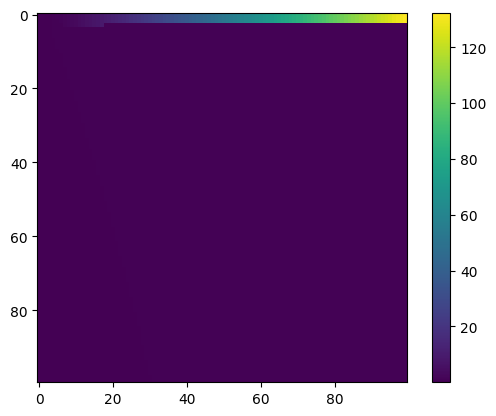

In [38]:
plt.imshow(np.imag(lam[:,:,4]))
plt.colorbar()

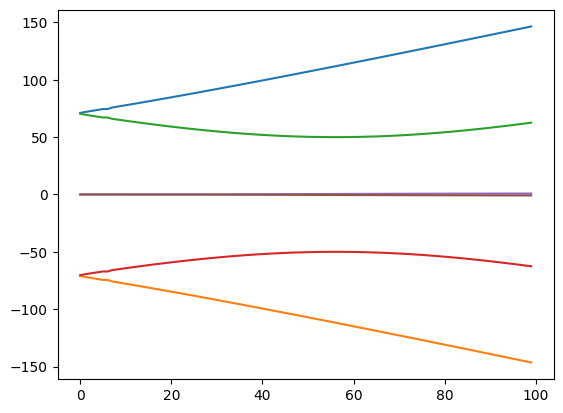

In [49]:
N_grid=100
qy_0_list=(np.linspace(1/N_grid,1,N_grid,endpoint=True)*1e2).astype(int)
P=1
lam=np.zeros((N_grid,6),dtype=complex)

N0=(P*del_omega)**3/(8*g_y**2)
for j,qy_0 in enumerate(qy_0_list):
    E=np.linalg.eigvals(evol_mat(del_omega,g_y,N0,qy_0))
    for k in range(6):
        lam[j,k]=E[k]
        
for i in range(6):
    plt.plot(np.imag(lam[:,i]))
    
plt.show()

In [50]:
lam[0,:]

array([ 1.39019724e-13+7.10852286e+01j,  1.39019724e-13-7.10852286e+01j,
       -1.41796100e-13+7.03521704e+01j, -1.41796100e-13-7.03521704e+01j,
       -8.41702100e-19+1.53729251e-04j, -8.41702100e-19-1.53729251e-04j])